In [23]:
import numpy as np
from scipy import integrate
import torch

import matplotlib
import matplotlib.pyplot as plt

0.36791950647965144


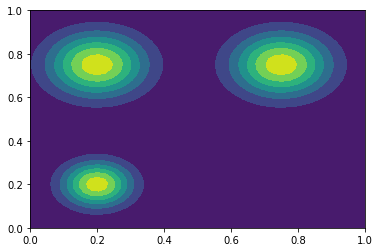

In [24]:
from probability_distribution import mu_gaussians, mu_display2D
U_shape = (1,1)
p1 = mu_gaussians([(0.2, 0.01), (0.75, 0.02), (np.array([0.2, 0.75]), 0.02)], U_shape)
print(p1(np.array([0.2,0.3])))
mu_display2D(p1, U_shape)


In [25]:
from fourier_functions import Fourier_Functions, Fourier_Functions_Visualize2D
import pickle 
mu = p1
K = 10
ff = Fourier_Functions(mu, U_shape, K, compute_mu=False, printProgress=True)
# for k in ff:
#     Fourier_Functions_Visualize2D(U_shape, ff[k])

with open(f'mu_k{K}.pkl', 'rb') as handle:
    mu_k = pickle.load(handle)
for k in ff:
    ff[k]['mu_k'] = mu_k[k]




Fourier Functions (mu, U_shape= (1, 1) , K= 10 )...
Computing constants (new_k, h_k, lambda_k)...
Computing torch fourier functions (f_k, df_k)...
Computing casadi fourier function (casadi_f_k)...
Aggregating all constants and functions into one dict...
Done.


In [26]:
from mm_agent import MMAgent1
from global_comm_agent_system import GlobalCommunicationSystem
from ergodic_agents import Agent, AgentSystem
# can only really test init rn
n = len(U_shape)
all_k = list(np.ndindex(*[K]*n))
agent1 = MMAgent1(0, np.array([0.2, 0.3]), 0.2, all_k, U_shape, ff, eps=1e-5)
for k in agent1.k_bands:
    print("mu"+str(k)+": ", ff[k]["mu_k"])
print("agent1 kbands: ", agent1.k_bands)
print("agent1 ck: ", agent1.get_c_k_log())
print("agent1 ergodicity: ", agent1.get_ergodicity_log())
print("agent1 position: ", agent1.get_position_log())
agent2 = MMAgent1(1, np.array([0.6, 0.5]), 0.2, all_k, U_shape, ff, eps=1e-5)
print(agent2.get_c_k_log())
print(agent2.get_ergodicity_log())
print(agent2.get_position_log())
print("system")
system1 = AgentSystem([agent1], mu, U_shape, ff, K)
print("system k_bands: ", list(system1.all_k_bands))
print("system c_k: ", system1.get_c_k_log())
print("system ergodicity: ", system1.get_ergodicity_log())

mu(0, 0):  0.1543442209624029
mu(0, 1):  -0.08192132336295474
mu(0, 2):  0.011260548433379342
mu(0, 3):  0.06936180862837646
mu(0, 4):  -0.1047215369239555
mu(0, 5):  0.012921186097392064
mu(0, 6):  -0.015636898584845516
mu(0, 7):  -0.014488585435384192
mu(0, 8):  0.009539032412849471
mu(0, 9):  0.0030859196339847565
mu(1, 0):  0.042007440083285885
mu(1, 1):  0.032151150968839505
mu(1, 2):  0.013669428472842832
mu(1, 3):  -0.007692333290117026
mu(1, 4):  -0.03172183268466088
mu(1, 5):  -0.02465016594182818
mu(1, 6):  -0.016602759201530176
mu(1, 7):  -0.005253907718654771
mu(1, 8):  0.0034524983155298063
mu(1, 9):  0.005237365167954495
mu(2, 0):  0.032267693514379026
mu(2, 1):  -0.00521271716951493
mu(2, 2):  0.004674646978975583
mu(2, 3):  0.008686963267559245
mu(2, 4):  -0.02259802084755251
mu(2, 5):  -0.0034620433902130556
mu(2, 6):  -0.005970810137897808
mu(2, 7):  -0.003315808678324357
mu(2, 8):  0.002181630223848787
mu(2, 9):  0.0016073942875769567
mu(3, 0):  0.010181407111921918


In [27]:
t = 0
delta_t = 0.1
for i in range(1000):
    t = i * delta_t
    system1.evolve(t, delta_t)


x_prev:  None
x_curr:  [0.21491519 0.31332431]
x_prev:  None
x_curr:  [0.22987939 0.32659355]
x_prev:  None
x_curr:  [0.2449291  0.33976572]
x_prev:  None
x_curr:  [0.26006697 0.35283648]


In [ ]:
print("System vs Agent 1 c_k")
print(len(system1.c_k_log))
print(agent1.system_c_k)
print(len(agent1.c_k_log))
k = (1,2)
print([system1.c_k_log[i][k] - agent1.c_k_log[i][k] for i in range(5)])
print([system1.c_k_log[-i][k] - agent1.c_k_log[-i][k] for i in range(5)])

System vs Agent 1 c_k
1001
None
1001
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]


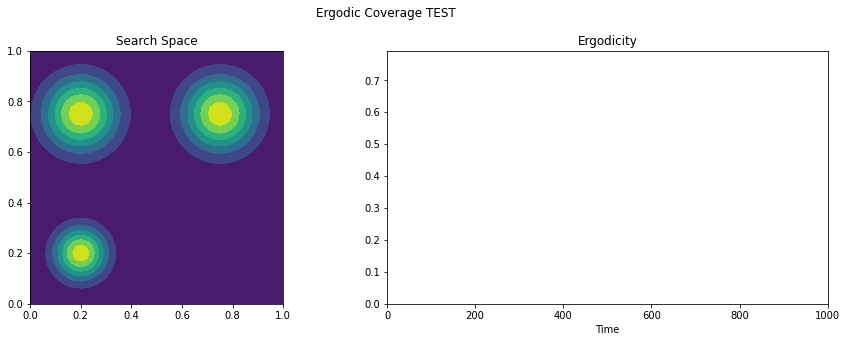

In [ ]:
system1.visualize2d(filename="test_without_c_k", additional_title="TEST", plot_c_k=False)

In [ ]:
def fourier_coefficient2distribution(ff, k_bands, c_k=None):
    def dist(x):
        res = 0
        for k in k_bands:
            if c_k is None:
                coeff_k = ff[k]['mu_k']
            else:
                coeff_k = c_k[k]
            res += coeff_k*ff[k]['f_k'](x)
        return res
    return dist

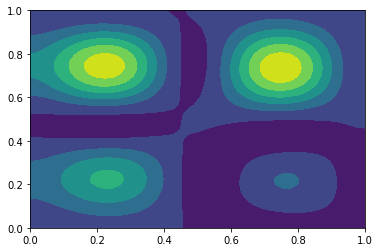

In [ ]:
recon_mu = fourier_coefficient2distribution(ff, all_k)
mu_display2D(recon_mu, U_shape)

[0.34173821 0.44096502]


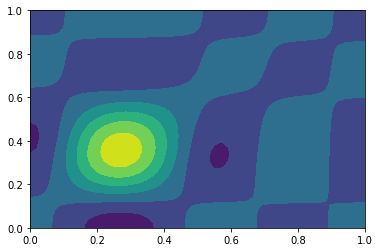

In [ ]:
i = 10
print(agent1.x_log[i])
recon_c_k = fourier_coefficient2distribution(ff, all_k, agent1.c_k_log[i])
mu_display2D(recon_c_k, U_shape)

[0.47977005 0.53632228]


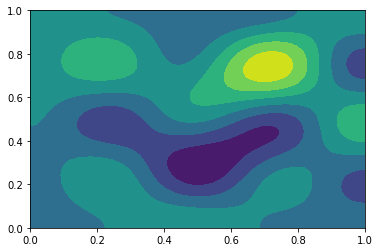

In [ ]:
i = -1
print(agent1.x_log[i])
recon_c_k = fourier_coefficient2distribution(ff, all_k, agent1.c_k_log[i])
mu_display2D(recon_c_k, U_shape)